**Importing**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv("/content/drive/MyDrive/Competitions/KDAG/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Competitions/KDAG/test.csv")

**Adding coeff to train**

In [ ]:
train['coeff'] = train['profit']/train['price']

**Dropping useless columns from both**

In [ ]:
train = train.drop(['departure city', 'no of items', 'segment', 'delivery type', 'RID', 'delivery date', 'address code', 'placement date'], axis=1)
test = test.drop(['departure city', 'no of items', 'segment', 'delivery type', 'RID', 'delivery date', 'address code', 'placement date'], axis=1)

**Integer Encoding Both based on train**

Here, test may get some null values 

In [ ]:
discCol = ['location', 'class', 'sub-class', 'departure state']
for col in discCol:
  valDict = train[col].value_counts().to_dict()
  num=0
  for i in valDict:
    valDict[i] = num
    num+=1
  
  train[col] = train[col].map(valDict)
  test[col] = test[col].map(valDict)

**Creating State Index in train and propagating it to test**

Careful if test contains some states not in train

In [ ]:
avgProfitState = train[['profit', 'departure state']].groupby('departure state').mean()

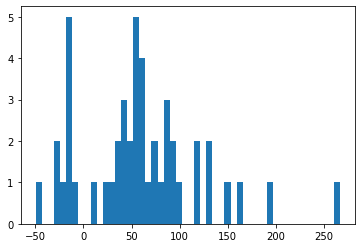

In [ ]:
plt.hist(avgProfitState['profit'], bins=50)
plt.show()

Here limits are arbitrarily chosen

In [ ]:
avgProfitStateDict = avgProfitState['profit'].to_dict()
for i in avgProfitStateDict:
  if(avgProfitStateDict[i]<0):
    avgProfitStateDict[i] = -1
  elif(avgProfitStateDict[i]>100):
    avgProfitStateDict[i] = 1
  else:
    avgProfitStateDict[i] = 0

In [ ]:
train['stateIndex'] = train['departure state'].map(avgProfitStateDict)

In [ ]:
test['stateIndex'] = test['departure state'].map(avgProfitStateDict)

In [ ]:
train = train.drop('departure state', axis=1)
test = test.drop('departure state', axis=1)

**Checking for NULL**

Test might have some NULL

In [ ]:
train.isnull().sum(), train.notnull().sum(), test.isnull().sum(), test.notnull().sum()

(id            0
 discount      0
 price         0
 location      0
 class         0
 sub-class     0
 profit        0
 coeff         0
 stateIndex    0
 dtype: int64, id            6700
 discount      6700
 price         6700
 location      6700
 class         6700
 sub-class     6700
 profit        6700
 coeff         6700
 stateIndex    6700
 dtype: int64, id             0
 discount       0
 price          0
 location       0
 class          0
 sub-class      0
 stateIndex    11
 dtype: int64, id            3294
 discount      3294
 price         3294
 location      3294
 class         3294
 sub-class     3294
 stateIndex    3283
 dtype: int64)

In [ ]:
test['stateIndex'] = test['stateIndex'].fillna(0)
test.isnull().sum(), test.notnull().sum()

(id            0
 discount      0
 price         0
 location      0
 class         0
 sub-class     0
 stateIndex    0
 dtype: int64, id            3294
 discount      3294
 price         3294
 location      3294
 class         3294
 sub-class     3294
 stateIndex    3294
 dtype: int64)

**Model**

In [ ]:
testIDS = test['id'].to_numpy()
Xtrain = train[['discount', 'price', 'location', 'class', 'sub-class', 'stateIndex']].to_numpy()
ytrain = train['coeff'].to_numpy()
ztrain = train['profit'].to_numpy()
Xtest = test[['discount', 'price', 'location', 'class', 'sub-class', 'stateIndex']].to_numpy()

In [ ]:
from sklearn.preprocessing import StandardScaler
scl1 = StandardScaler()
XtrainScaled = scl1.fit_transform(Xtrain)
XtestScaled = scl1.transform(Xtest)

**Dtree**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=9, min_samples_leaf=10)

from sklearn.model_selection import cross_validate
cv = cross_validate(dtr, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.95845232, 0.95550171, 0.95864855, 0.95456807]),
 array([0.95029695, 0.95565275, 0.94204374, 0.9451503 ]))

In [ ]:
dtr.fit(XtrainScaled, ytrain)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

**SVM**

In [ ]:
from sklearn.svm import SVR
svr = SVR(C=15)

from sklearn.model_selection import cross_validate
cv = cross_validate(svr, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.94866988, 0.94702283, 0.95077459, 0.95026083]),
 array([0.94056705, 0.94902533, 0.93423059, 0.93047068]))

In [ ]:
svr.fit(XtrainScaled, ytrain)

SVR(C=15, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

**Voting**

In [ ]:
from sklearn.ensemble import VotingRegressor
vr = VotingRegressor(estimators=[('svr', svr), ('dtr', dtr)])

from sklearn.model_selection import cross_validate
cv = cross_validate(vr, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.95798332, 0.956563  , 0.9591326 , 0.9575604 ]),
 array([0.95141833, 0.95680602, 0.94406552, 0.94571527]))

In [ ]:
vr.fit(XtrainScaled, ytrain)

VotingRegressor(estimators=[('svr',
                             SVR(C=15, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False)),
                            ('dtr',
                             DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse', max_depth=9,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=10,
                                                   min_samples_split=2,
                                                   min_weight_fract

In [ ]:
ypreds = vr.predict(XtestScaled)

**Stage2**

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

X2train = (ytrain*Xtrain[:,1]).reshape(-1,1)
X2test = (ypreds*Xtest[:,1]).reshape(-1,1)

In [ ]:
cv = cross_validate(lr, X2train, ztrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]))

In [ ]:
lr.fit(X2train, ztrain)
zpreds = lr.predict(X2test)

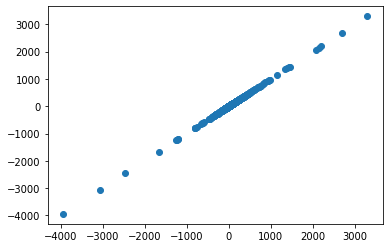

In [ ]:
plt.scatter(zpreds,zpreds)

In [ ]:
res = pd.DataFrame({'id':testIDS, 'profit':zpreds})
res

,id,profit
0,6701,6.815137
1,6702,38.182784
2,6703,1.081552
3,6704,3.968669
4,6705,33.571756
...,...,...
3289,9990,7.597350
3290,9991,8.723192
3291,9992,40.432419
3292,9993,4.049378


In [ ]:
#res.to_csv("/content/drive/MyDrive/Competitions/KDAG (1)/FinalResult.csv", index=False)